# Softmax(Pytorch)

In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from keras.datasets import mnist
import matplotlib.pyplot as plt

Using TensorFlow backend.


## 1. Load dataset

这里使用Keras的minist数据集.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.reshape(x_train.shape[0],-1) / 255
x_test = x_test.reshape(x_test.shape[0],-1) / 255

## 2. Forward

构建pytorch的向前传播.

线性层的结构为:(input units, output units)

In [4]:
class Model_softmax(nn.Module):
    """
    Build forward propagation 
    """
    def __init__(self,layers):
        """
        Initialization linear model. Linear-->relu-->Linear-->...-->Output layer
        
        Arguments:
        ---------
            layers: #hidden layer's units.
        """
        nn.Module.__init__(self)
        self.L = len(layers)
        # build linear model.
        self.linears = nn.ModuleList([nn.Linear(layers[l],layers[l+1]) for l in range(self.L - 1)])
        print('Model Sumarray:')
        print(self.linears)
        # change weights initializer value,using "He".
        [nn.init.kaiming_uniform_(linear.weight) for linear in self.linears]
    
    def forward(self,X):
        """
        build forward propagation.
        
        Arguments:
        ---------
            X: data set, shape like (m_sample,features)
        Return:
        ------
            X: output layer value. shape is (m_sample,n_classes)
            Notice:it have not through any activate function,because,we use loss function is nn.CrossEntropyLoss(),
                it's euqal nn.LogSoftmax() + nn.NLLLoss().
        """
        for l in range(self.L -1):
            X = self.linears[l](X)
            if l != self.L - 2:
                X = torch.relu(X)
            else:
                return X

In [15]:
layers = [x_train.shape[1],25,12,10]
model = Model_softmax(layers)
X = Variable(torch.from_numpy(x_train)).float()
X = model.forward(X)
print('\nThe softmax check:')
print(torch.sum(torch.softmax(X,dim=1),dim=1))
print('\nThe output layer shape is:')
print(X.size())

Model Sumarray:
ModuleList(
  (0): Linear(in_features=784, out_features=25, bias=True)
  (1): Linear(in_features=25, out_features=12, bias=True)
  (2): Linear(in_features=12, out_features=10, bias=True)
)

The softmax check:
tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward2>)

The output layer shape is:
torch.Size([60000, 10])


接下来我们可以搭建Pytorch of Softmax Model.

## 3. Score

这里我们搭建测试模型时的评分函数,用于查看在训练过程中trian/validation的loss与correct rate.

In [6]:
def score(model,cost,data,labels,is_loss=False):
    """
    Score Function
    Arguments:
    ---------
        model: pytorch model.
        cost: loss function,In this case we use ```nn.CrossEntropyLoss()```.
        data: score data.
        labels: score loss
        is_loss: calculate loss with given score data, if is_loss equal True.default False
    
    Returns:
        acc: score data's correct rate.
        loss: score data's loss value.
    """
    out = model.forward(data)
    softmax_out = torch.softmax(out,dim=1)
    predict = torch.argmax(softmax_out,dim=1)
    correct_ = torch.eq(predict,labels).type(torch.FloatTensor)
    acc = torch.mean(correct_)
    if is_loss:
        loss = cost(out,labels)
        return acc,loss
    else:
        return acc    

## 4. Create Softmax Model

下面我们开始搭建Softmax Model.

(1) 因为我们在测试阶段是无需计算数据/标签的梯度渐变的,所以我们使用```with torch.no_grad():```来设置测试阶段的数据/标签.

```python
with torch.no_grad():
    ...```
    
(2) 我们选择[nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)来计算loss,对于该损失函数有两点需要主要的:

>(2.1) 该函数不支持"One-Hot"的形式,所以我们传入的True labels的形状为(m_smaple,)或者(m_smaple,1),该损失函数会依据类索引进行计算也就是如下形式(更多详细查看[RuntimeError: multi-target not supported (newbie)
](https://discuss.pytorch.org/t/runtimeerror-multi-target-not-supported-newbie/10216)):

<img src="../../../picture/123.png" width=300 height=300>

> (2.2) 该函数的target argument 需要是Long类型,所以我们在```with torch.no_grad():```使用```torch.LongTensor(labels)```的形式.


(3) 我们使用Pytorch自己的数据集划分Mini-Batchs与Tensorflow不同的是,Pytorch的方式简单许多只有两步:

(3.1) ```Data.TensorDataset(X_tensor,y_tensor)```:将需要划分的tensor data 放入,多元素以元组的方式.

(3.2) ```Data.DataLoader```:划分数据集,该函数自身就是一个迭代器

- ```dataset```:要划分的数据集
- ```batch_size```:每一轮的批次
- ```shuffle```:每一个epoch是否需要打乱原数据,这里我们应该选择打乱.
- ```num_workers```:是否以多线程的方式快速加载划分数据集,需要注意的是,线程的数量不可过多,会爬虫的朋友应该都熟悉.

In [7]:
def softmax(layers,data,labels,val_data,val_labels,lr,epochs,BATCH_SIZE):
    """
    Implement Softmax Model.
    
    Arguments:
    ---------
        layers: hidden layers units
        data: training data set.
        labels: training data labels.
        val_data: validation data set.
        val_labels: validation data labels.
        lr: learning rate.
        epochs: #Iterate.
        BATCH_SIZE: batch size.
    Returns:
    -------
        train_loss_list: include train set  loss value.
        val_loss_list: include val data set  loss value.
        train_accs_list: include train set  correct rate.
        val_accs_list: include val set correct rate.
    """
    # Pretreatment
    m,n = data.shape
    n_classes = len(np.unique(labels))
    layers.insert(0,n)
    
    # using testing model, don't caculate grad !
    with torch.no_grad():
        data_tensor = Variable(torch.FloatTensor(data))
        labels_tensor = Variable(torch.LongTensor(labels))
        
        val_data_tensor = Variable(torch.FloatTensor(val_data))
        val_labels_tensor = Variable(torch.LongTensor(val_labels))
        
        
    # Create Model
    model = Model_softmax(layers)
    # using CrossEntropyLoss
    cost = nn.CrossEntropyLoss()
    # using Adam Optimizer.
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    
    # Split Mini-Batchs.
    X_tensor = torch.Tensor(data)
    y_tensor = torch.LongTensor(labels) # It's Long type must be careful !
    data_set = Data.TensorDataset(X_tensor,y_tensor)
    loder = Data.DataLoader(dataset=data_set,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
    
    # cache loss and correct rate
    train_loss_list = []
    val_loss_list = []
    train_accs_list = []
    val_accs_list = []
    
    # Strat training.
    for epoch in range(epochs):
        for mini_x,mini_y in loder:
            
            out = model.forward(mini_x)
            
            loss = cost(out,mini_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Testing Time.
        acc_train,loss_train = score(model,cost,data_tensor,labels_tensor,is_loss=True)
        acc_val,loss_val = score(model,cost,val_data_tensor,val_labels_tensor,is_loss=True)
        
        train_accs_list.append(acc_train);train_loss_list.append(loss_train)
        val_accs_list.append(acc_val);val_loss_list.append(loss_val)
        
        print('\033[0;35m [{}/{}] loss:{:.4f},acc_train:{:.4f},val_loss:{:.4f},acc_val:{:.4f}\033[0m\r'.format(
        epoch+1,epochs,loss_train,acc_train,loss_val,acc_val),end="",flush=True)
        
    return train_loss_list,train_accs_list,val_loss_list,val_accs_list
        

In [11]:
layers = [25,12,10]
train_loss,train_accs,val_loss,val_accs = softmax(layers,x_train,y_train,x_test,y_test,lr=0.001,
                                                  epochs=20,BATCH_SIZE=64)

Model Sumarray:
ModuleList(
  (0): Linear(in_features=784, out_features=25, bias=True)
  (1): Linear(in_features=25, out_features=12, bias=True)
  (2): Linear(in_features=12, out_features=10, bias=True)
)


可以看到与Softmax(Application)中的结果非常相似.并且有请微微的过拟合发生,接下去我们来绘制一下Accuracy/Loss.

## 5. Plot Accuracy/Loss

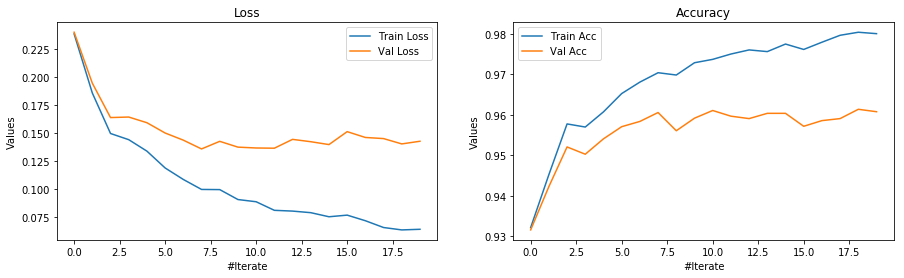

In [12]:
figure = plt.figure(figsize=(15,4))
ax1 = figure.add_subplot(1,2,1)
ax1.plot(train_loss,label="Train Loss")
ax1.plot(val_loss,label="Val Loss")
ax1.set_title('Loss')
ax1.set_xlabel('#Iterate')
ax1.set_ylabel('Values')
ax1.legend()

ax2 = figure.add_subplot(1,2,2)
ax2.plot(train_accs,label="Train Acc")
ax2.plot(val_accs,label="Val Acc")
ax2.set_title('Accuracy')
ax2.set_xlabel('#Iterate')
ax2.set_ylabel('Values')
ax2.legend()

可以看到确实有轻微微过拟合发生,我们可以选择最简单的办法early-stop,来解决此类轻微微过拟合.